In [29]:
# Alzheimer MRI Classification using GNN

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [30]:

# --- Configurations ---
BATCH_SIZE = 32
EPOCHS = 75
IMG_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data Preprocessing ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

data_dir = "./data"
train_dataset = ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = ImageFolder(os.path.join(data_dir, "val"), transform=transform)

label_map = train_dataset.class_to_idx
inv_label_map = {v: k for k, v in label_map.items()}


In [31]:

# --- Convert image tensors to graph data ---
def image_to_graph(image_tensor, label):
    c, h, w = image_tensor.shape
    nodes = h * w
    x = image_tensor.view(1, -1).squeeze().unsqueeze(1)
    edge_index = []
    for row in range(h):
        for col in range(w):
            idx = row * w + col
            if col + 1 < w:
                edge_index.append([idx, idx + 1])
            if row + 1 < h:
                edge_index.append([idx, idx + w])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

train_graphs = [image_to_graph(img, lbl) for img, lbl in tqdm(train_dataset, desc="Processing Train")]
val_graphs = [image_to_graph(img, lbl) for img, lbl in tqdm(val_dataset, desc="Processing Val")]

graph_train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
graph_val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE)


Processing Val: 100%|██████████| 6400/6400 [01:32<00:00, 68.87it/s] 
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [32]:

# --- GNN Model ---
class GCNClassifier(torch.nn.Module):
    def __init__(self, hidden_channels=64, num_classes=4):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


In [33]:

# --- Training and Evaluation ---
def train_and_evaluate(model, model_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(DEVICE)
    train_loss_list, val_acc_list = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for data in graph_train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_list.append(total_loss / len(graph_train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        preds, targets = [], []
        with torch.no_grad():
            for data in graph_val_loader:
                data = data.to(DEVICE)
                out = model(data)
                pred = out.argmax(dim=1)
                correct += int((pred == data.y).sum())
                total += len(data.y)
                preds.extend(pred.cpu().numpy())
                targets.extend(data.y.cpu().numpy())

        val_acc = correct / total
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Plot loss and accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Loss')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title("Validation Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(xticks_rotation=45)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Classification Report
    print(classification_report(targets, preds, target_names=list(label_map.keys())))


Epoch 1/75, Loss: 1441.4042, Val Accuracy: 0.2778
Epoch 2/75, Loss: 1429.4838, Val Accuracy: 0.4617
Epoch 3/75, Loss: 1428.3369, Val Accuracy: 0.4022
Epoch 4/75, Loss: 1427.8725, Val Accuracy: 0.4644
Epoch 5/75, Loss: 1427.3423, Val Accuracy: 0.4855
Epoch 6/75, Loss: 1425.8237, Val Accuracy: 0.4448
Epoch 7/75, Loss: 1423.8045, Val Accuracy: 0.4469
Epoch 8/75, Loss: 1420.9470, Val Accuracy: 0.4867
Epoch 9/75, Loss: 1414.7817, Val Accuracy: 0.4859
Epoch 10/75, Loss: 1406.8286, Val Accuracy: 0.4939
Epoch 11/75, Loss: 1398.7122, Val Accuracy: 0.4900
Epoch 12/75, Loss: 1392.7701, Val Accuracy: 0.3602
Epoch 13/75, Loss: 1388.7867, Val Accuracy: 0.5042
Epoch 14/75, Loss: 1387.7591, Val Accuracy: 0.5028
Epoch 15/75, Loss: 1385.3269, Val Accuracy: 0.5083
Epoch 16/75, Loss: 1386.7869, Val Accuracy: 0.4881
Epoch 17/75, Loss: 1383.5974, Val Accuracy: 0.5109
Epoch 18/75, Loss: 1383.6747, Val Accuracy: 0.5112
Epoch 19/75, Loss: 1385.7023, Val Accuracy: 0.5022
Epoch 20/75, Loss: 1384.6608, Val Accura

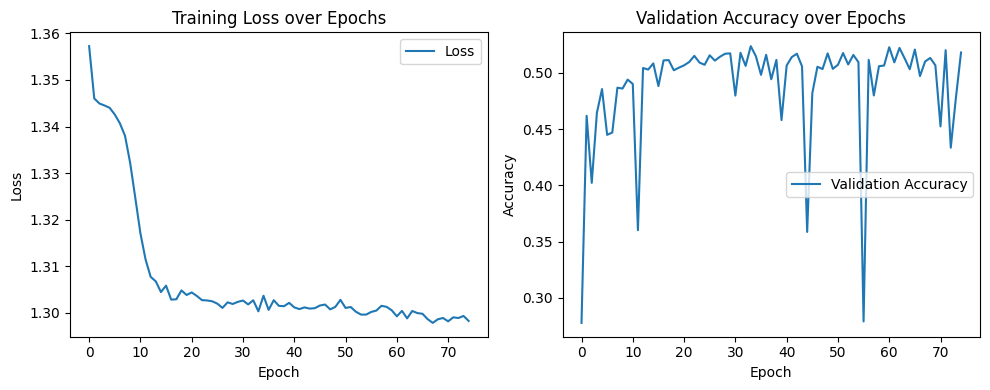

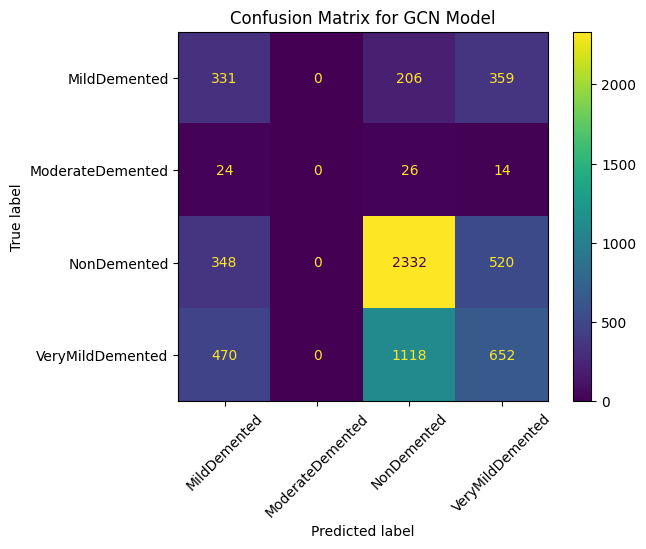

                  precision    recall  f1-score   support

    MildDemented       0.28      0.37      0.32       896
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.63      0.73      0.68      3200
VeryMildDemented       0.42      0.29      0.34      2240

        accuracy                           0.52      6400
       macro avg       0.33      0.35      0.34      6400
    weighted avg       0.50      0.52      0.50      6400



c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [34]:

# --- Run Models ---
if __name__ == "__main__":
    gcn_model = GCNClassifier()
    train_and_evaluate(gcn_model, "GCN Model")


In [35]:

# --- Predict Single Image ---
def predict_image(image_path, model):
    model.eval()
    # Apply transformations to the image
    img = Image.open(image_path)
    img = transforms.Grayscale()(img)
    img = transforms.Resize((IMG_SIZE, IMG_SIZE))(img)
    img = transforms.ToTensor()(img)
    
    # Convert the image to graph data
    graph = image_to_graph(img, 0)  # Dummy label
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)
    
    # Perform prediction
    with torch.no_grad():
        out = model(graph.to(DEVICE))
        probs = F.softmax(out, dim=1).cpu().numpy().flatten()
        pred_idx = np.argmax(probs)
        label = inv_label_map[pred_idx]
        confidence = probs[pred_idx] * 100
        print(f"Prediction: {label} ({confidence:.2f}%)")

In [36]:

# Example usage:
# predict_image("./data/val/NonDemented/example.jpg", gcn_model)


In [38]:
torch.save(gcn_model.state_dict(), "gcn_model.pth")


In [39]:
gcn_model = GCNClassifier()
gcn_model.load_state_dict(torch.load("gcn_model.pth"))
gcn_model.eval()


C:\Users\molim\AppData\Local\Temp\ipykernel_38388\4055422508.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load("gcn_model.pth"))


GCNClassifier(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)

In [40]:
predict_image("./data/val/NonDemented/26 (62).jpg", gcn_model)

Prediction: NonDemented (31.68%)
